In [1]:
] activate ..

  Activating environment at `e:\Pythonfiles\JP\ML\Project.toml`


In [2]:
using DifferentialEquations
using LinearAlgebra, DiffEqSensitivity, Optim
using Flux: flatten, params
using DiffEqFlux, Flux
using Plots
using Flux: train!
using NNlib
using GalacticOptim
using Optim

# Chapter 1 Optimization method to estimate parameters.

## 1.1. Generate data.

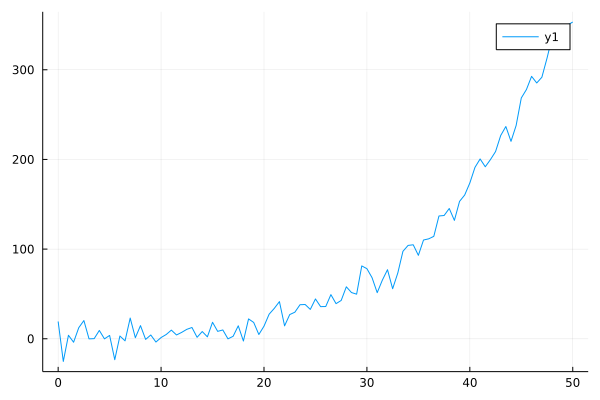

In [21]:
# Data generation
function SEIAR(du,u,p,t)
    β, k1, k2, σ, ρ, γ1, γ2 = p
   S, E, I, A = u
   du[1] = - β*S*(I+k1*E+k2*A)/1000
   du[2] = β*S*(I+k1*E+k2*A)/1000 - σ*E
   du[3] =  σ*(1-ρ)*E-γ1*I
   du[4] = σ*ρ*E-γ2*A
   du[5] = σ*E
end
u_0 = [1000, 1, 1, 1,0]
p_data = [0.3,0.3,0.3,1/5.2,0.3,1/10,1/10]
tspan_data = (0.0, 50)
prob_data = ODEProblem(SEIAR,u_0,tspan_data,p_data)
data_solve = solve(prob_data, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.5)
data_withoutnois = Array(data_solve)
data = data_withoutnois + Float32(10)*randn(eltype(data_withoutnois), size(data_withoutnois))
tspan_predict = (0.0, 4.0)
prob_predict = ODEProblem(SEIAR,u_0,tspan_predict,p_data)
test_data = solve(prob_predict, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)

plot(data_solve.t, data[5,:])

Model

In [25]:
# Define the 
function SEIAR_pred(du,u,p,t)
    β, k1, k2, ρ= p
    σ, γ1, γ2 = 1/5.2,1/10,1/10
   S, E, I, A = u
   du[1] = - β*S*(I+k1*E+k2*A)/1000
   du[2] = β*S*(I+k1*E+k2*A)/1000 - σ*E
   du[3] =  σ*(1-ρ)*E-γ1*I
   du[4] = σ*ρ*E-γ2*A
   du[5] = σ*E
end
u_0 = [1000, 1, 1, 1,0]
p_0 = [0.1,0.1,0.1,0.1]
prob_pred = ODEProblem(SEIAR_pred,u_0,tspan_data,p_0)

# Define the loss
function train(θ)
    Array(concrete_solve(prob_pred, Vern7(), u_0, θ, saveat = 0.5,
                         abstol=1e-6, reltol=1e-6,
                         sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
 end
 function loss(θ)
    pred = train(θ)
    sum(abs2, (data[5,:] .- pred[5,:]))+sum(abs2, (data[3,:] .- pred[3,:])), pred # + 1e-5*sum(sum.(abs, params(ann)))
 end
 println(loss(p_0))
 const losses = []
 callback(θ,l,pred) = begin
    push!(losses, l)
    if length(losses)%50==0
        println(losses[end])
    end
    false
 end
 lb = [0, 0, 0, 0]
 ub = [1,1,1,1]
 res1_node = DiffEqFlux.sciml_train(loss, p_0, ADAM(0.01),lower_bounds=lb,upper_bounds=ub, cb=callback, maxiters = 500)
 res2_node = DiffEqFlux.sciml_train(loss, res1_node.minimizer, BBO(),lower_bounds=lb,upper_bounds=ub,cb=callback, maxiters = 1000)
 
println(loss(res2_node.u)[1]-loss([0.3,0.3,0.3,0.3])[1])



(1.8746779098697277e6, [1000.0 999.9393143148536 999.877386548582 999.8143915131545 999.7504811999926 999.6857877590277 999.6204260889774 999.5544960895398 999.4880846195814 999.4212671997385 999.3541094927332 999.2866685903978 999.218994132713 999.151129280741 999.0831115624643 999.014973608235 998.9467437901947 998.8784467782162 998.8101040231769 998.7417341772014 998.6733534590084 998.6049759715843 998.5366139783233 998.4682781431001 998.3999777390659 998.3317208301188 998.2635144287417 998.1953646331755 998.1272767466592 998.0592553811846 997.9913045476296 997.9234277341627 997.8556279744316 997.7879079067915 997.7202698258054 997.6527157270831 997.585247346194 997.5178661925225 997.4505735787445 997.38337064643 997.3162583882739 997.2492376674429 997.1823092344346 997.1154737416681 997.0487317561859 996.9820837707377 996.9155302134178 996.8490714560274 996.7827078213293 996.7164395893618 996.650267002971 996.5841902725638 996.5182095802135 996.4523250832721 996.3865369175347 996.3


47853.3710244817
34057.583020317215
25902.062777083844
22095.86800407647
20660.354929579997
20214.278781701505
20097.977444331213
20071.720757723306
20065.89598956218
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
1.945344005675103e6
446965.9839015289
1.8779015562411658e6
3.835901251330563e7
1.7706812516729345e6
232468.92391691246
71400.47327685125
347797.54130909586
492341.2799916033
230668.76597856754
1.049295680557306e6
1.7504836050226662e7
28153.831257783742
54764.293936913346
78957.57519079576
927412.9792148238
197907.49809815938
1.4412108021753876e7
1.892484996603204e6
4.496851991596611e6

Optimization stopped after 1001 steps and 0.19 seconds
Termination reason: Max number of steps (1000) reached
Steps per second = 5324.46
Function evals per second = 6037.23
Improvements/step = 0.22900
Total function evaluations = 1135


Be

In [30]:
# Define the loss
function train(θ)
    Array(concrete_solve(prob_pred, Vern7(), u_0, θ, saveat=0.5,
                         abstol=1e-6, reltol=1e-6,
                         sensealg=InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end
function loss(θ,p)
    pred = train(θ)
    sum(abs2, (data[5,:] .- pred[5,:])) + sum(abs2, (data[3,:] .- pred[3,:])) # + 1e-5*sum(sum.(abs, params(ann)))
end
println(loss([0.3,0.3,0.3,0.3],p_0))
lb = [0, 0.01, 0, 0]
ub = [1,1,1,1]
using GalacticOptim: OptimizationProblem
using Optim
prob = OptimizationProblem(loss, p_0, lb = lb, ub = ub)
sol = solve(prob, NelderMead())

using BlackBoxOptim
prob = OptimizationProblem(loss, p_0, lb = lb, ub = ub)
sol = GalacticOptim.solve(prob,BBO());
sol.minimum


20984.815330096768
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 3293 evals, 3195 steps, improv/step: 0.133 (last = 0.1333), fitness=20077.833765309
1.00 secs, 6920 evals, 6824 steps, improv/step: 0.132 (last = 0.1306), fitness=19817.100683471

Optimization stopped after 10001 steps and 1.49 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 6689.63
Function evals per second = 6752.51
Improvements/step = 0.12900
Total function evaluations = 10095


Best candidate found: [0.212789, 0.87731, 8.17485e-6, 0.344643]

Fitness: 19815.378852615



19815.37885261524

[0.20081943851495587, 1.033301291809703, -0.16723793139307247, 0.3466782856487127]


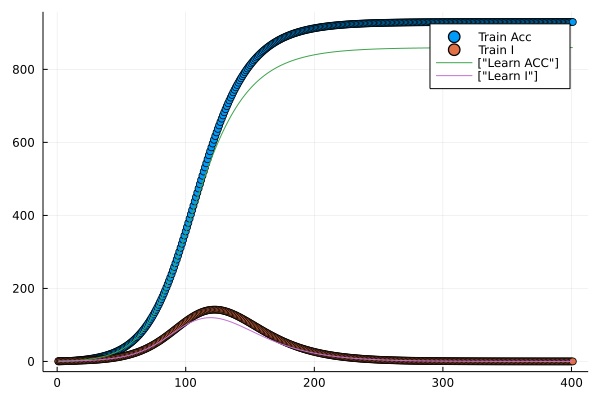

In [24]:
# Data visualization
println(res2_node.u)
tspan_predict = (0.0,200)
prob_test = ODEProblem(SEIAR,u_0,tspan_predict,p_data)
data_test = Array(solve(prob_test, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.5))
scatter(data_test[5,:],label = "Train Acc")
scatter!(data_test[3,:],label = "Train I")
prob_prediction = ODEProblem(SEIAR_pred, u_0, tspan_predict, res2_node.minimizer)
data_prediction = Array(solve(prob_prediction, Tsit5(), saveat = 0.5))
plot!(data_prediction[5,:],label=["Learn ACC"])
plot!(data_prediction[3,:],label=["Learn I"])

In [ ]:
@model function fitlv2(data, prob1) # data should be a Vector
    σ ~ InverseGamma(2, 3) # ~ is the tilde character
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)

    p = [α,β,γ,δ]
    prob = remake(prob1, p=p)
    predicted = solve(prob,Tsit5(),saveat=0.1)

    for i = 1:length(predicted)
        data[i] ~ Normal(predicted[i][2], σ) # predicted[i][2] is the data for y - a scalar, so we use Normal instead of MvNormal
    end
end

model2 = fitlv2(odedata[2,:], prob1)

In [ ]:
ann_node = FastChain(FastDense(3, 32, tanh),FastDense(32, 1))
p = Float64.(initial_params(ann_node))
p_know = [1/5.2,0.3,1/10,1/10]
function SEIAR_nn(du,u,p,t)
   σ, ρ, γ1, γ2 = p_know
  S, E, I, A = u
  du[1] = - S*ann_node([E,I,A],p)[1]
  du[2] = S*ann_node([E,I,A],p)[1] - σ*E
  du[3] =  σ*(1-ρ)*E-γ1*I
  du[4] = σ*ρ*E-γ2*A
end
prob_nn = ODEProblem(SEIAR_nn, u_0, tspan_data, p)
function train(θ)
   Array(concrete_solve(prob_nn, Vern7(), u_0, θ, saveat = 0.1,
                        abstol=1e-6, reltol=1e-6,
                        sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end
function loss(θ)
   pred = train(θ)
   sum(abs2, (data .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))
end
#println(loss(p))
const losses = []
callback(θ,l,pred) = begin
   push!(losses, l)
   if length(losses)%50==0
       println(losses[end])
   end
   false
end
res1_node = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=callback, maxiters = 500)
res2_node = DiffEqFlux.sciml_train(loss, res1_node.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 1000)
scatter(data_solve.t, data[1,:],label = "Train S")
scatter(data_solve.t, data[2,:],label = "Train E")
scatter!(data_solve.t, data[3,:],label = "Train I")
scatter!(data_solve.t, data[3,:],label = "Train A")
plot!(test_data, label=["Test S" "Test E" "Test I" "Test A"])


prob_nn2 = ODEProblem(SIR_nn, u_0, tspan_predict, res2_node.minimizer)
s_nn = solve(prob_nn2, Tsit5(), saveat = 0.1)
plot!(s_nn,label=["Learn S" "Learn E" "Learn I" "Learn A"])